# Users and Variance

This notebook will analyse the arrivals of users (whether it is linear or not) and how it affects the variance and the mean of the metrics

In [1]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.linear_model import LinearRegression
from matplotlib.collections import PolyCollection
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
base_path = os.path.abspath('')
all_data = True

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")


events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0


In [3]:
cum_users = pd.DataFrame()

for d in events_df["date"].unique():
    this_df = events_df[events_df["date"] <= d]
    users_df = (this_df
           .groupby("user_id")
           .agg({
                "event_type_purchase":          ["sum", "max"],
                "sales":                        ["sum"],
           })
           ).reset_index()
    users_df.columns = ["user_id", "n_purchases", "has_purchase", "sales"]
    for c in users_df.columns[1:]:
        users_df[f"{c}_sq"] = users_df[c]**2
    aggregated = (
        users_df
        .agg({
            "user_id":"count",
            "n_purchases":"sum",
            "n_purchases_sq":"sum",
            "has_purchase":"sum",
            "sales":"sum",
            "sales_sq":"sum",
        })
        )
    this_line=pd.DataFrame({"date":[d], "cum_users": [aggregated["user_id"]], 
                            "n_purchases_mean":[aggregated["n_purchases"]/aggregated["user_id"]],
                            "n_purchases_sd":[((aggregated["n_purchases_sq"]/aggregated["user_id"])-(aggregated["n_purchases"]/aggregated["user_id"])**2)**(1/2)],
                            "has_purchase_mean":[aggregated["has_purchase"]/aggregated["user_id"]],
                            "has_purchase_sd":[((aggregated["has_purchase"]/aggregated["user_id"])-(aggregated["has_purchase"]/aggregated["user_id"])**2)**(1/2)],
                            "sales_mean":[aggregated["sales"]/aggregated["user_id"]],
                            "sales_sd":[((aggregated["sales_sq"]/aggregated["user_id"])-(aggregated["sales"]/aggregated["user_id"])**2)**(1/2)],
                            })
    cum_users = pd.concat([cum_users, this_line])
cum_users.reset_index(drop=True)
cum_users["days"] = (pd.to_datetime(cum_users["date"]) - pd.to_datetime(cum_users["date"]).min()).dt.days + 1


(-6.550000000000001, 159.55, 0.0, 1724431.349342105)

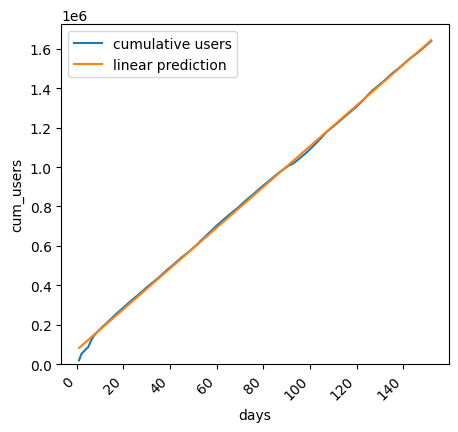

In [80]:
lr = LinearRegression()
lr = lr.fit(X=cum_users["days"].values.reshape(-1, 1), y=cum_users["cum_users"])
lr.predict(X=cum_users["days"].values.reshape(-1, 1))
cum_users["predicted_users"] = lr.predict(X=cum_users["days"].values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=cum_users, x="days", y="cum_users", label="cumulative users")
sns.lineplot(data=cum_users, x="days", y="predicted_users", label="linear prediction")
fig.autofmt_xdate(rotation=45)
ax.axis(ymin=0)

The increase seems to be exponential at first but then it becomes linear as most old users already appeared. This could be because there is a low retention of users or because we are unable to track them after a few days. Let's zoom in the first days:

In [55]:
lr.coef_

array([0.8784629])

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_91581/524449470.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cum_users_2020["predicted_users"] = lr.predict(X=cum_users_2020["days"].values.reshape(-1, 1))


(-0.4500000000000002, 31.45, 0.0, 422540.35838709667)

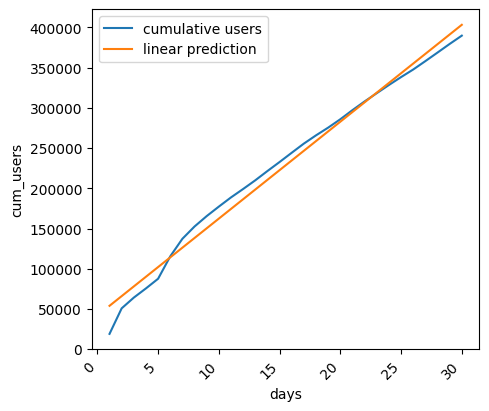

In [79]:
lr = LinearRegression()
llogr = LinearRegression()
cum_users_2020 = cum_users.loc[cum_users["date"]<="2019-10-30"]

lr = lr.fit(X=cum_users_2020["days"].values.reshape(-1, 1), y=cum_users_2020["cum_users"])
lr.predict(X=cum_users_2020["days"].values.reshape(-1, 1))
# llogr = llogr.fit(X=np.log(cum_users_2020["days"].values.reshape(-1, 1)), y=np.log(cum_users_2020["cum_users"]))
# llogr.predict(X=cum_users_2020["days"].values.reshape(-1, 1))

cum_users_2020["predicted_users"] = lr.predict(X=cum_users_2020["days"].values.reshape(-1, 1))
# cum_users_2020["log_predicted_users"] = np.exp(llogr.predict(X=np.log(cum_users_2020["days"].values.reshape(-1, 1))))

fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=cum_users_2020, x="days", y="cum_users", label="cumulative users")
sns.lineplot(data=cum_users_2020, x="days", y="predicted_users", label="linear prediction")
# sns.lineplot(data=cum_users_2020, x="days", y="log_predicted_users")
fig.autofmt_xdate(rotation=45)
ax.axis(ymin=0)

We can see that the effect is more pronounced here. Let's see how does it affect the metrics:

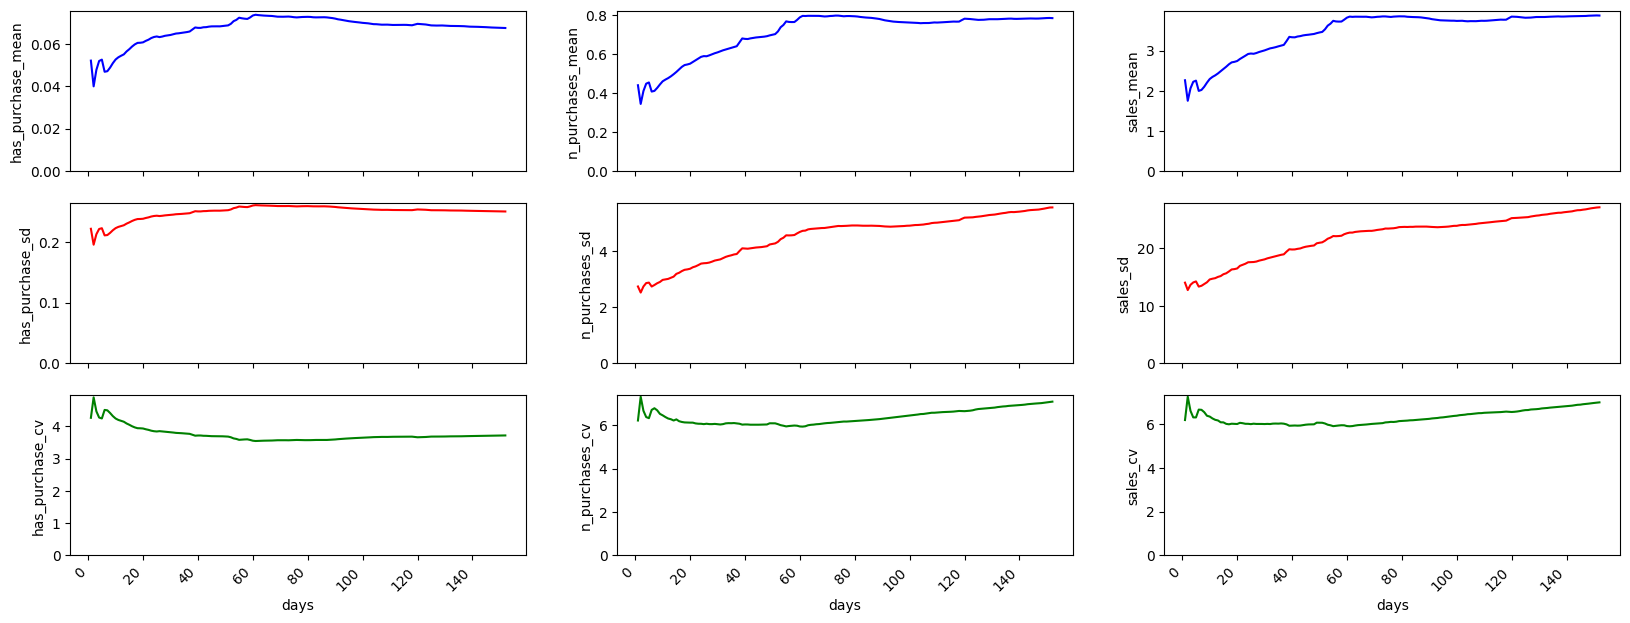

In [41]:
metrics = ["has_purchase", "n_purchases", "sales",]
colors = ["blue", "red", "green", "yellow", "purple"]
fig, ax = plt.subplots(3, len(metrics), figsize=(20, 8))

for i, m in enumerate(metrics):
    cum_users[f"{m}_cv"] = cum_users[f"{m}_sd"]/cum_users[f"{m}_mean"]
    sns.lineplot(data=cum_users, x="days", y=f"{m}_mean", ax=ax[0,i], color=colors[0])
    sns.lineplot(data=cum_users, x="days", y=f"{m}_sd", ax=ax[1,i], color=colors[1])
    sns.lineplot(data=cum_users, x="days", y=f"{m}_cv", ax=ax[2,i], color=colors[2])
    
    ax[0,i].axis(ymin=0)
    ax[1,i].axis(ymin=0)
    ax[2,i].axis(ymin=0)

fig.autofmt_xdate(rotation=45)

The mean of every metric seems to stabilize after ~2 months, but the std keeps increasing after a plateau. The cv (which we'll use to determine power) starts decreasing with time, but at then increases again... something seems to be off

<Axes: xlabel='date'>

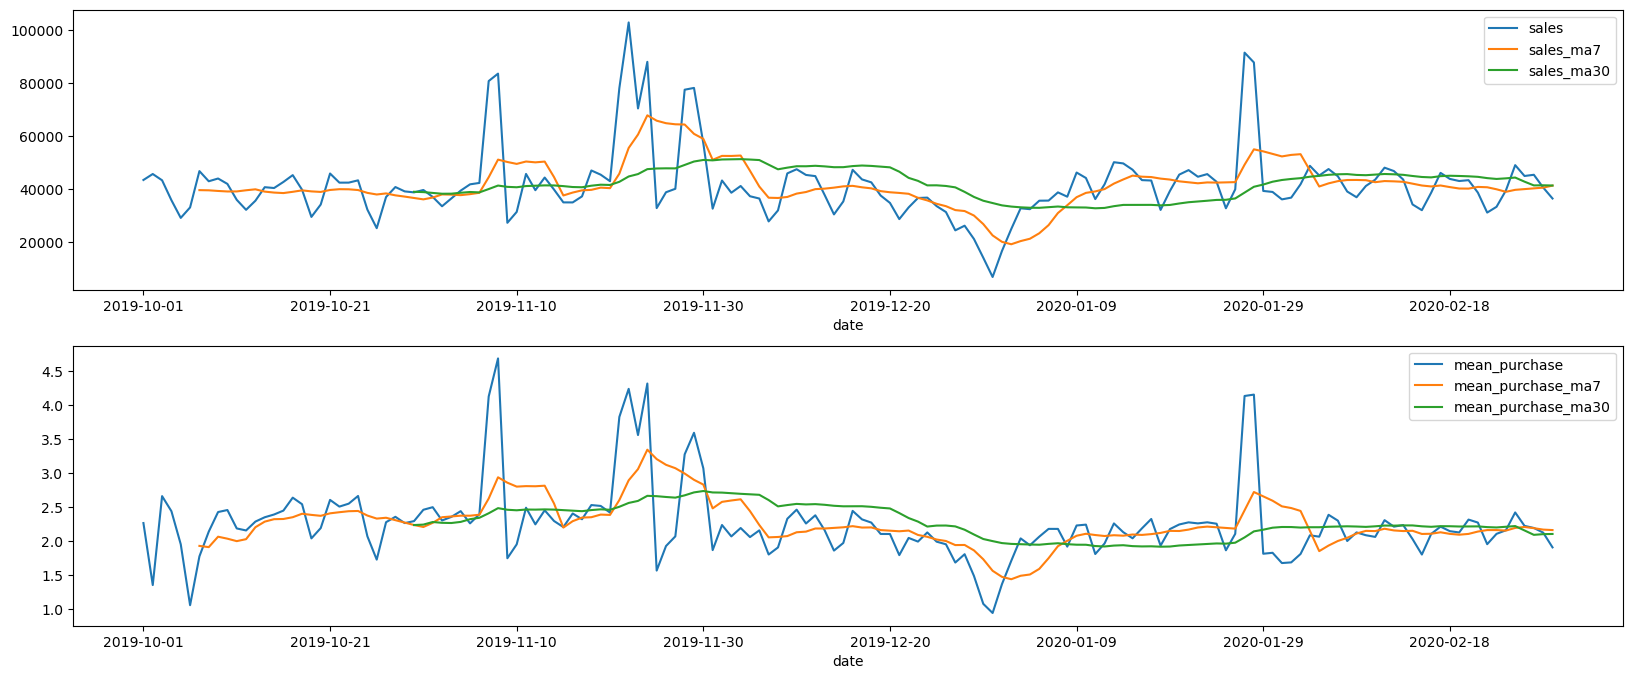

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
sales_by_user_day = events_df.groupby("date").agg({"sales":"sum", "user_id": "nunique"}).reset_index()

sales_by_user_day['sales_ma7'] = sales_by_user_day['sales'].rolling(7).mean()
sales_by_user_day['sales_ma30'] = sales_by_user_day['sales'].rolling(30).mean()

sales_by_user_day["mean_purchase"] = sales_by_user_day["sales"] / sales_by_user_day["user_id"]
sales_by_user_day['mean_purchase_ma7'] = sales_by_user_day['mean_purchase'].rolling(7).mean()
sales_by_user_day['mean_purchase_ma30'] = sales_by_user_day['mean_purchase'].rolling(30).mean()

sales_by_user_day.plot(x="date", y=["sales", "sales_ma7", "sales_ma30"], ax=ax[0])
sales_by_user_day.plot(x="date", y=["mean_purchase", "mean_purchase_ma7", "mean_purchase_ma30"], ax=ax[1])


There seems to be a change around new year. While total sales is similar, the average sale by user is lower. Since we don't have enough information from other years to assess seasonal effects, we'll consider that the following months (where we expect to run the experiments) behave more similar to january and february than to the latest months of the year, so we'll use data from 2020 to assess sample size

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_36057/1440026760.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


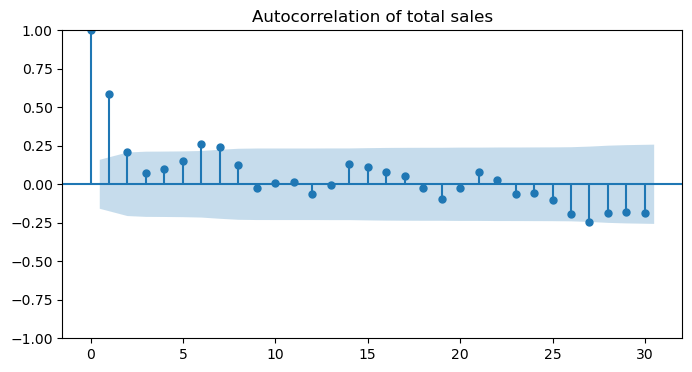

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(x=sales_by_user_day["sales"], lags=30, ax=ax, title="Autocorrelation of total sales")
fig.show()

There also seem to be a signifficant weekly seasonality, which would indicate us that the experiments shouldn't be ran for less than a week